In [9]:
import torch
import torch.nn as nn
import h5py
import numpy as np
import torchvision.transforms.functional as TF
from torchvision.utils import save_image
from PIL import Image
from dataset import CustomDataset
from math import sqrt
from torch.utils.data import DataLoader
from model import ConvModel
import matplotlib.pyplot as plt 

In [10]:
model = ConvModel(in_channels=1, num_targets=8)
model.load_state_dict(torch.load('./results/model.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [11]:
#dic with energies of elements
dic={ 'Ca':3692,'Mn':5900,'Fe':6405,'Cu':8046,'Au':9713,'Hg':9989,'Pb':10551,'Sr':14165}
num_elements=len(dic)

f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/panagia1_mm.h5', 'r')
dset=f['dataset']
dEset=f['energies']
spectra_p=np.array(dset)
energies=np.array(dEset)
f.close()

f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/christ.h5', 'r')
dset=f['dataset']
spectra_c=np.array(dset)
f.close()

f = h5py.File('C:/Users/ioann/Documents/GitHub/Hyperspectral-Image-Analysis/data/hand.h5', 'r')
dset=f['dataset']
spectra_h=np.array(dset)
f.close()


channels=100
rows_p=41
cols_p=65
rows_c=31
cols_c=46
rows_h=41
cols_h=21

spectra_p = spectra_p.astype(np.float32)
spectra_c = spectra_c.astype(np.float32)
spectra_h = spectra_h.astype(np.float32)
spectra_p=np.delete(spectra_p,np.s_[:channels],1)
spectra_c=np.delete(spectra_c,np.s_[:channels],1)
spectra_h=np.delete(spectra_h,np.s_[:channels],1)

energies=np.delete(energies,np.s_[:channels])

#roi function    
def fwhm(ev):
    #print(sqrt(2.47*ev+4400))
    return sqrt(2.47*ev+4400)

X_p=torch.tensor(spectra_p)
X_c=torch.tensor(spectra_c)
X_h=torch.tensor(spectra_h)


key_list=list(dic.keys())
min_ch=[]
max_ch=[]
min_roi_all=[]
max_roi_all=[]
for element in dic:
    min_roi=(dic[element]-fwhm(dic[element])/2)
    min_roi_all.append(min_roi)
    max_roi=(dic[element]+fwhm(dic[element])/2)
    max_roi_all.append(max_roi)
    min_ch.append(int((min_roi+960)/20)-channels)
    max_ch.append(int((max_roi+960)/20)-channels)


y_p=np.zeros([len(spectra_p),num_elements])
for i in range(len(spectra_p)):
    for j in range(len(key_list)):
        y_p[i][j]=np.sum(np.sum(spectra_p[i,min_ch[j]:max_ch[j]]))
y_c=np.zeros([len(spectra_c),num_elements])
for i in range(len(spectra_c)):
    for j in range(len(key_list)):
        y_c[i][j]=np.sum(np.sum(spectra_c[i,min_ch[j]:max_ch[j]]))
y_h=np.zeros([len(spectra_h),num_elements])
for i in range(len(spectra_h)):
    for j in range(len(key_list)):
        y_h[i][j]=np.sum(np.sum(spectra_h[i,min_ch[j]:max_ch[j]]))

y_p, y_c, y_h = torch.tensor(y_p), torch.tensor(y_c), torch.tensor(y_h)

In [28]:


dataSet = CustomDataset(
    (X_p, y_p), (X_c, y_c)
)

dataLoader = DataLoader(
    dataset=dataSet, 
    batch_size=32, 
    shuffle=False
)

model = ConvModel(in_channels=1, num_targets=8)
optimizer = torch.optim.Adam(model.parameters(), lr=float(0.0002))

dataSet.setTrain(True)

spectra_list = list()

for idx, (x_in, y_in) in enumerate(dataLoader):
    
    x_in = torch.reshape(x_in, (x_in.shape[0], 1, x_in.shape[1]))    

    with torch.no_grad():
        y_pred = model(x_in)
        
        for spectra in y_pred:
            spectra_list.append(np.array(spectra))


print(len(spectra_list))

2665


In [29]:
len(spectra_list[0])

8

In [30]:
spectra_list_arr=np.array(spectra_list)

In [31]:
spectra_list_arr.shape

(2665, 8)

In [33]:
spectra_cube=spectra_list_arr.reshape(41,65,8)

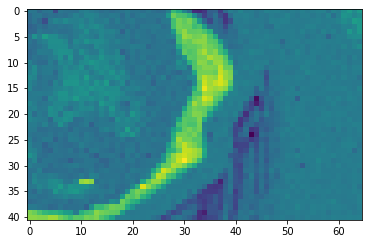

In [41]:
plt.imshow(spectra_cube[:,:,3])